# Importing the libraries

In [5]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm
import wrds
import os
from sklearn.preprocessing import StandardScaler
from dotenv import load_dotenv
import jsonlines
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px

import matplotlib
import matplotlib.pyplot as plt

import umap

import warnings
warnings.filterwarnings('ignore')

# Set the font to Times New Roman
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'

load_dotenv()

True

# Set the parameters and configurations

In [6]:
nlp_model = 'mpnet' 
doc2vec_vector_size = 768

previously_wrds_gvkey_index = True
previously_downloaded_recoms = True
previously_done_cosines = True
previously_done_cosines_inds = True

exemplar_identification_stnd = 1

min_words_per_doc = 200
max_words_per_doc = 100000

ind_type = 'naicsh' # 'sich' or 'naicsh' #naicsh and sich are historical industry codes for companies
ind_col = 'naicsh6' 
ind_base_sims = 'naicsh2' # this is used to measure pairwise similarities between companies within the industry level
ind_dist_level= 'naicsh2' # this is used to measure pairwise similarities between sub-industries within the industry level

# Specify the path to your file
file_path = '../data/Item1_wrds_html_text_embeds_MPNET.jsonl'
filing_source= 'htm_txt_sic'

# Load embeddings from JSONL file into a dataframe

In [3]:

# This list will hold each json object (i.e., each line in the file)
data = []

# Open the file
with jsonlines.open(file_path, mode='r') as reader:
    # Read each json object
    for obj in reader:
        # Append the object to our list
        data.append(obj)

# Convert the list to a DataFrame
df = pd.DataFrame(data)

# Convert the 'embedding' column into separate columns
embedding_df = pd.DataFrame(df['embedding'].to_list(), columns=[f'embedding_{i}' for i in range(768)])

# Drop the original 'embedding' column from df
df = df.drop(columns=['embedding'])

# Concatenate the original DataFrame (without the 'embedding' column) and embedding_df
df = pd.concat([df, embedding_df], axis=1)

df_select = df[df.n_words> min_words_per_doc]
df_select = df_select[df_select.n_words< max_words_per_doc]

doc_vectors = df_select.drop(columns=['n_words']).set_index(['file_id'])


In [4]:
doc_vectors

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
file_id,,,,,,,,,,,,,,,,,,,,,
c2ab4ce585034769aa94e915c87da7de,0.002899,0.006903,-0.011355,0.009924,0.019930,0.014085,0.005501,0.006059,-0.021735,-0.009431,...,-0.038134,-0.011096,0.016168,0.003653,0.009458,-0.011895,0.001601,-0.010757,-0.034947,-0.003155
8b1465de42df4c688be1e1de29ab20ce,0.003066,0.000483,-0.015694,-0.009114,-0.002435,0.000261,0.037446,-0.013413,-0.017749,-0.016088,...,-0.023370,-0.001455,0.023226,0.016201,0.003695,-0.013231,-0.013786,-0.007117,-0.037774,-0.011473
d6919d2b74774a40b5f92d75adec0ca1,0.029543,0.007013,-0.014453,-0.001947,0.000639,-0.015389,0.019610,0.010941,-0.021068,0.000133,...,-0.016806,0.003998,0.004650,0.023070,-0.008954,0.016543,-0.012386,-0.013622,-0.039193,-0.013740
a4f261a4a35a4bff9f01aee474ebd5db,0.009957,-0.004499,-0.004919,-0.013769,0.012452,0.023038,0.008014,0.014261,0.004244,0.004505,...,-0.040784,0.004949,0.006005,0.017059,-0.012614,-0.022730,0.001950,0.010650,-0.032636,0.001754
58d0419e0d214a11887a65e2094f3b9c,0.024503,0.018064,-0.001508,-0.008471,0.011776,0.017118,0.002723,0.012063,-0.018754,-0.009717,...,-0.023230,-0.002256,0.007169,0.011513,0.001163,-0.010701,-0.002545,0.006841,-0.016960,-0.014362
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9d00837c84114d0caafd5acb48227d07,0.011490,0.021431,-0.020304,0.005748,0.004727,0.005583,0.020347,-0.006725,0.001282,-0.015746,...,-0.009625,0.005004,0.003597,0.019456,0.005023,0.005914,-0.002740,0.000121,-0.036192,-0.018654
bf40fe8525ae4a5e92e7dff6c014936e,0.014762,0.029746,0.011246,0.014355,-0.008471,0.001249,0.027429,0.024553,-0.033604,0.016041,...,-0.052925,-0.017331,-0.010340,0.010356,-0.004844,-0.031338,0.004351,-0.014408,-0.006455,0.012988
5b05ce72c52b4ccd88b3755862961c87,0.004874,0.020397,-0.003928,0.003821,0.004286,0.008648,0.011663,0.006546,-0.002584,-0.005060,...,-0.034113,-0.007433,0.005895,0.016754,-0.000197,-0.009868,-0.004550,-0.002805,-0.049656,-0.004957




# Adding GVKEY identifier to filings index from wrds

In [7]:
# This is needed for adding the industry codes to the index file
# creating the mapping file

# This file needs to be downloaded from WRDS web interface directly
# WRDS does not have a standalone database for CRSP/Compustat Merged, rather, it creates it on the fly per user request
# Download the file with WRDS default settings, from 1989 to 2023
# I have transformed the file into a pickle file for faster loading; note that this is not an option when downloading the file from WRDS (it's csv, dta, SAS, etc.)
compustat_crsp = pd.read_pickle('../data/csrp_compustat1989_2023.pkl')


In [ ]:

compustat_crsp=compustat_crsp[compustat_crsp.datafmt=='STD']
compustat_crsp=compustat_crsp[compustat_crsp.popsrc=='D']
compustat_crsp=compustat_crsp[compustat_crsp.consol=='C']
compustat_crsp=compustat_crsp[compustat_crsp.indfmt== 'INDL']

compustat_crsp['month']=compustat_crsp['datadate'].dt.month
compustat_crsp['year']=compustat_crsp['datadate'].dt.year
compustat_crsp['cusip_8']=compustat_crsp.cusip.apply(lambda x: x[:8])
compustat_crsp.drop_duplicates(['GVKEY','datadate'], inplace=True)
compustat_crsp.drop_duplicates(['cusip_8','year'], inplace=True)
compustat_crsp.drop_duplicates(['cik','year'], inplace=True)
compustat_crsp['GVKEY'] = compustat_crsp['GVKEY'].astype(int)

compustat_select = compustat_crsp[['GVKEY', 'datadate','year','month','cik', 'cusip_8', 'conm', 'sich', 'naicsh']]

compustat_select.dropna(subset=['cik'], inplace=True)
compustat_select['cik']  = compustat_select['cik'].astype(str) 
compustat_select = compustat_select[compustat_select['cik'].str.len() > 0]
compustat_select['cik']  = compustat_select['cik'].astype(int)


if ind_type == 'sich':
  compustat_select['sich'] = compustat_select['sich'].replace('', np.nan)
  compustat_select = compustat_select.loc[compustat_select['sich'].notna()]
  compustat_select.loc[:, 'sich4'] = compustat_select['sich'].astype(int).astype(str).str.pad(width=4, side='right', fillchar='0').astype(int)
  compustat_select.loc[:, 'sich3'] = compustat_select['sich4'] // 10
  compustat_select.loc[:, 'sich2'] = compustat_select['sich4'] // 100


elif ind_type == 'naicsh':
  compustat_select['naicsh'] = compustat_select['naicsh'].replace('', np.nan)
  compustat_select = compustat_select.loc[compustat_select['naicsh'].notna()]
  compustat_select.loc[:, 'naicsh6'] = compustat_select['naicsh'].astype(int).astype(str).str.pad(width=6, side='right', fillchar='0').astype(int)
  compustat_select.loc[:, 'naicsh5'] = compustat_select['naicsh6'] // 10
  compustat_select.loc[:, 'naicsh4'] = compustat_select['naicsh6'] // 100
  compustat_select.loc[:, 'naicsh3'] = compustat_select['naicsh6'] // 1000
  compustat_select.loc[:, 'naicsh2'] = compustat_select['naicsh6'] // 10000


In [4]:
compustat_select.head()

,GVKEY,datadate,year,month,cik,cusip_8,conm,sich,naicsh,naicsh6,naicsh5,naicsh4,naicsh3,naicsh2
0,1004,1990-05-31,1990,5,1750,00036110,AAR CORP,5080.0,421860.0,421860,42186,4218,421,42
1,1004,1991-05-31,1991,5,1750,00036110,AAR CORP,5080.0,421860.0,421860,42186,4218,421,42
2,1004,1992-05-31,1992,5,1750,00036110,AAR CORP,5080.0,421860.0,421860,42186,4218,421,42
3,1004,1993-05-31,1993,5,1750,00036110,AAR CORP,5080.0,421860.0,421860,42186,4218,421,42
4,1004,1994-05-31,1994,5,1750,00036110,AAR CORP,5080.0,421860.0,421860,42186,4218,421,42


In [20]:
# Adding the GVKEY from crsp_compustat to wrds_index

wrds_index = pd.read_csv('../data/WRDS_SEC_1994_2022.csv')
wrds_index['rdate'] = pd.to_datetime(wrds_index['rdate'], format='%Y%m%d')


In [8]:

# Merge on the date and CIK columns
wrds_index = pd.merge(wrds_index, compustat_select, on=['cik'], how='outer')
wrds_index['delta'] = wrds_index['datadate'] - wrds_index['rdate']
wrds_index['delta'] =wrds_index['delta'].dt.days
wrds_index = wrds_index[(wrds_index['delta']<10) & (wrds_index['delta']>-10)] # this could be changed to account for the fact that the filing date is not always the same as the date of the financial statement
wrds_index.drop_duplicates(['GVKEY', 'datadate'], inplace=True)
wrds_index.to_csv(f'../data/WRDS_SEC_1994_2022_gvkey_{filing_source}.csv')

wrds_index = wrds_index[['GVKEY', 'datadate', 'year', ind_base_sims, 'id']]

# keep only wrds_index where id is availabe in doc_vectors index
wrds_index = wrds_index[wrds_index['id'].isin(doc_vectors.index)]

In [11]:
wrds_index.shape

(20, 5)

In [10]:

# Compute cosine similarities between documents
if not previously_done_cosines:
    wrds_index_merge = pd.merge(wrds_index, wrds_index, on=[ind_base_sims  , 'year'], how='outer', suffixes=('','_2'))
    wrds_index_merge = wrds_index_merge[wrds_index_merge['id'] != wrds_index_merge['id_2']]
    indices = wrds_index_merge[['id', 'id_2']].values
    chunk_size = 100000  # Size of chunks
    num_chunks = len(indices) // chunk_size + 1

    cosine_similarities = np.zeros(len(indices))
    for chunk_idx in range(num_chunks):
        start_idx = chunk_idx * chunk_size
        end_idx = min((chunk_idx + 1) * chunk_size, len(indices))

        vectors1 = doc_vectors.loc[indices[start_idx:end_idx, 0]].values
        vectors2 = doc_vectors.loc[indices[start_idx:end_idx, 1]].values

        dot_products = np.einsum('ij,ij->i', vectors1, vectors2)
        norms = np.linalg.norm(vectors1, axis=1) * np.linalg.norm(vectors2, axis=1)
        cosine_similarities[start_idx:end_idx] = dot_products / norms

        print(f'Chunk {chunk_idx + 1} out of {num_chunks} done')

    wrds_index_merge['similarity'] = cosine_similarities
    wrds_index_merge.columns = ['gvkey1', 'datadate', 'year', ind_base_sims, 'file_index', 'gvkey2', 'datadate_2', 'file_index_2', 'score']
    wrds_index_merge.to_pickle(f'../data/NLP/sims_all_{nlp_model}_{str(doc2vec_vector_size)}_{ind_type}.pkl')

else:
    wrds_index_merge = pd.read_pickle(f'../data/NLP/sims_all_{nlp_model}_{str(doc2vec_vector_size)}_{ind_type}.pkl')


In [11]:
wrds_index_merge.score.describe()


count    5.044980e+07
mean     7.019005e-01
std      1.319192e-01
min     -2.465694e-02
25%      6.201079e-01
50%      7.099581e-01
75%      7.945753e-01
max      1.000000e+00
Name: score, dtype: float64

<Axes: >

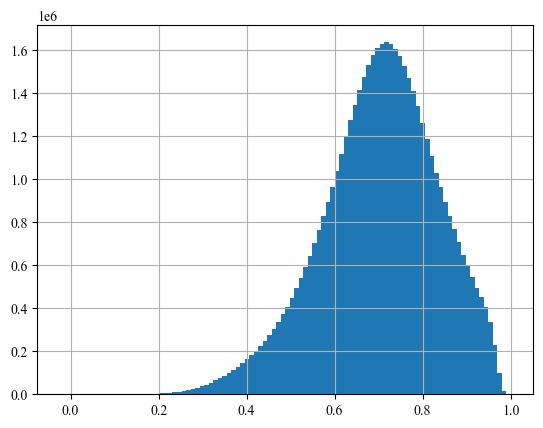

In [12]:
# plot the distribution of similarities
wrds_index_merge.score.hist(bins=100)

# Exemplar Identification


In [13]:

# Reading the recoms summary file

""" Selecting exemplars for each firm
"""
if previously_downloaded_recoms == False:
    wrds_username = os.getenv('WRDS_USERNAME')
    wrds_password = os.getenv('WRDS_PASSWORD')
    db_wrds = wrds.Connection(wrds_username=wrds_username, wrds_password=wrds_password)

    # replace with wrdssec.forms
    query = """
        SELECT *
        FROM ibes.recdsum
    """
    
    # Execute the SQL query and load the result into a pandas DataFrame
    recoms_sum = db_wrds.raw_sql(query)
    
    recoms_sum.to_csv('../data/recoms_summary_1996_2022.csv', index=False)
    
else:
    recoms_sum = pd.read_csv('../data/recoms_summary_1996_2022.csv', encoding='latin-1')




recoms_sum.columns = recoms_sum.columns.str.lower()


In [ ]:

# for dates in 8-digit format, ex. 20001209
def full_date_to_month(date):
    year=date//10000
    month=(date-(year*10000))//100
    day=date-(year*10000)-(month*100)
    if day<15:    
        month_f=month-1
    else:
        month_f=month
    if month_f==0:
        return 12
    else:
        return month_f
def full_date_to_year(date):
    return date//10000


recoms_sum['month']=recoms_sum['statpers'].apply(lambda x: full_date_to_month(x))
recoms_sum['year']=recoms_sum['statpers'].apply(lambda x: full_date_to_year(x) )
recoms_sum.drop_duplicates(subset=['cusip','year','month'], inplace=True)
recoms_sum['cusip']=recoms_sum['cusip'].astype(str)

# Creating annual average 
recoms_sum_agg=recoms_sum.groupby(['cusip','year'])[['meanrec', 'numrec']].agg('mean').reset_index()
recoms_sum_agg.drop_duplicates(subset=['cusip','year'], inplace=True)

# Merge Compustat database with IBES to find out what was the average recommendation for a firm each year
compustat_recoms=pd.merge(compustat_select, recoms_sum
                          , left_on=['cusip_8','year','month']
                          , right_on=['cusip','year','month'] , how='left')

compustat_recoms=pd.merge(compustat_recoms, recoms_sum_agg
                          , left_on=['cusip_8','year']
                          , right_on=['cusip','year'] 
                          , how='left', suffixes= ('','_mean'))



compustat_recoms = compustat_recoms[['GVKEY', 'datadate', f'{ind_col}'
                                     , 'month', 'year', 'cusip_8','meanrec','numrec','cusip','meanrec_mean', 'numrec_mean']]
                                     
compustat_recoms.drop_duplicates(['GVKEY', 'datadate'])



# Correcting the direction of MEANRECs
compustat_recoms.loc[:,'meanrec_descend'] = 6 - compustat_recoms['meanrec']
compustat_recoms.loc[:,'meanrec_mean_descend']= 6 -compustat_recoms['meanrec_mean']
compustat_recoms.loc[:,'numrec_mean_0'] = compustat_recoms['numrec_mean'].fillna(0)
database=compustat_recoms.copy()

In [14]:
database

,GVKEY,datadate,naicsh6,month,year,cusip_8,meanrec,numrec,cusip,meanrec_mean,numrec_mean,meanrec_descend,meanrec_mean_descend,numrec_mean_0
0,1004,1990-05-31,421860,5,1990,00036110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1004,1991-05-31,421860,5,1991,00036110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1004,1992-05-31,421860,5,1992,00036110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,1004,1993-05-31,421860,5,1993,00036110,NaN,NaN,NaN,4.335,2.0,NaN,1.665,2.0
4,1004,1994-05-31,421860,5,1994,00036110,3.5,4.0,00036110,3.517,3.9,2.5,2.483,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193846,348892,2021-12-31,333241,12,2021,58343510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
193847,349530,2022-02-28,541810,2,2022,65344G20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
193848,349972,2021-12-31,325414,12,2021,45339J10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
193849,350681,2021-12-31,518210,12,2021,37428A10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


## Creating a composite variable and designating firms with one standard deviation above the mean as exemplars

In [15]:
scaler = StandardScaler()

database_stand=scaler.fit_transform(
    database[['numrec_mean_0','meanrec_mean_descend']])

database_stand=pd.DataFrame(database_stand
             , columns=['numrec_stnd','mean_rec_stnd'])    

database_stand.index = database.index

database=pd.concat([database, database_stand], axis=1)    

database['composite_var'] = database.apply(
    lambda x: x.numrec_stnd+x.mean_rec_stnd , axis = 1)
    
database.drop(columns=['numrec_stnd','mean_rec_stnd'],
              inplace=True)               

ind_cols = [f'{ind_col}']

for naics in ind_cols:
    stnd= exemplar_identification_stnd
    database['temp_std'] = database.groupby([naics,'year'])['composite_var']\
        .transform('std')        
    database['temp_mean'] = database.groupby([naics,'year'])['composite_var']\
       .transform('mean')
    
    exemplar_col = f"exemplar_{naics}"
    
    database[exemplar_col] = database.apply(
        lambda x: True if (x['composite_var']>(x['temp_mean']+(stnd*x['temp_std']))) 
        else False, axis=1)



In [16]:
database[database[f'exemplar_{ind_col}']==True][['GVKEY', 'datadate', f'{ind_col}', 'numrec_mean_0', 'meanrec_mean_descend']]

,GVKEY,datadate,naicsh6,numrec_mean_0,meanrec_mean_descend
7,1004,1997-05-31,421860,5.818182,4.200909
8,1004,1998-05-31,421860,7.000000,4.519091
10,1004,2000-05-31,421860,7.300000,4.324000
63,1013,2006-10-31,334210,20.400000,3.617000
64,1013,2007-10-31,334210,22.272727,3.518182
...,...,...,...,...,...
193749,318005,2021-12-31,325414,17.500000,3.934000
193754,318728,2019-12-31,524113,15.800000,3.994000
193818,328795,2020-12-31,332312,6.454545,4.214545
193835,339965,2021-01-31,518210,27.800000,3.508000


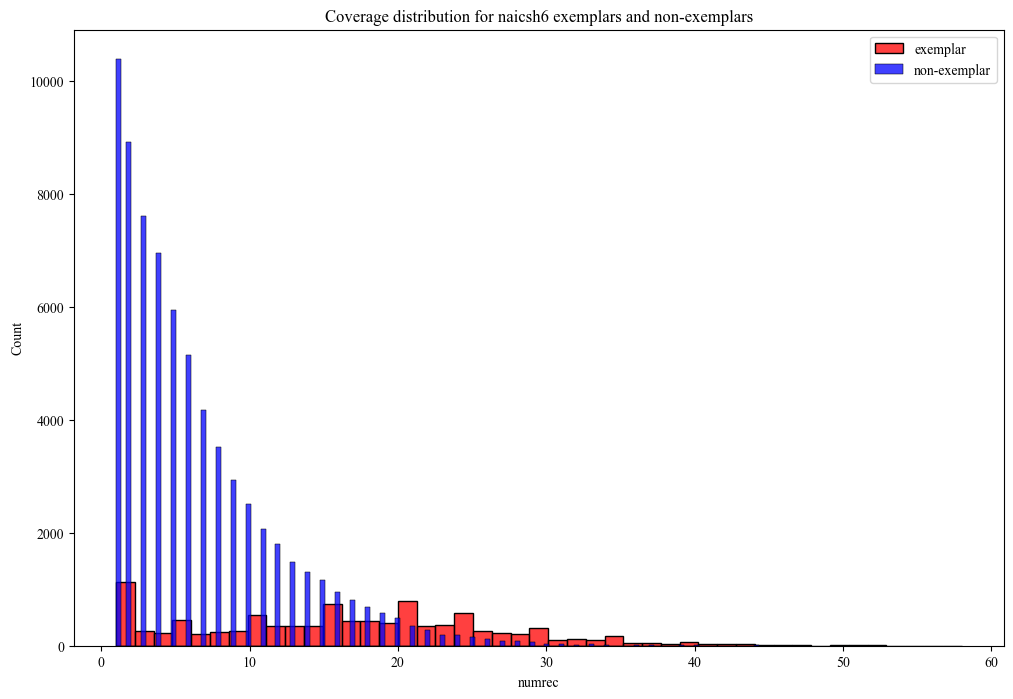

In [17]:
# plot the distribution of numrec_mean_0 for f'exemplar_{ind_col}' == True and False in the same plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=database[database[f'exemplar_{ind_col}']==True], x='numrec', ax=ax, color='red', label='exemplar')
sns.histplot(data=database[database[f'exemplar_{ind_col}']==False], x='numrec', ax=ax, color='blue', label='non-exemplar')
ax.legend()
ax.set_title(f'Coverage distribution for {ind_col} exemplars and non-exemplars')
plt.show()


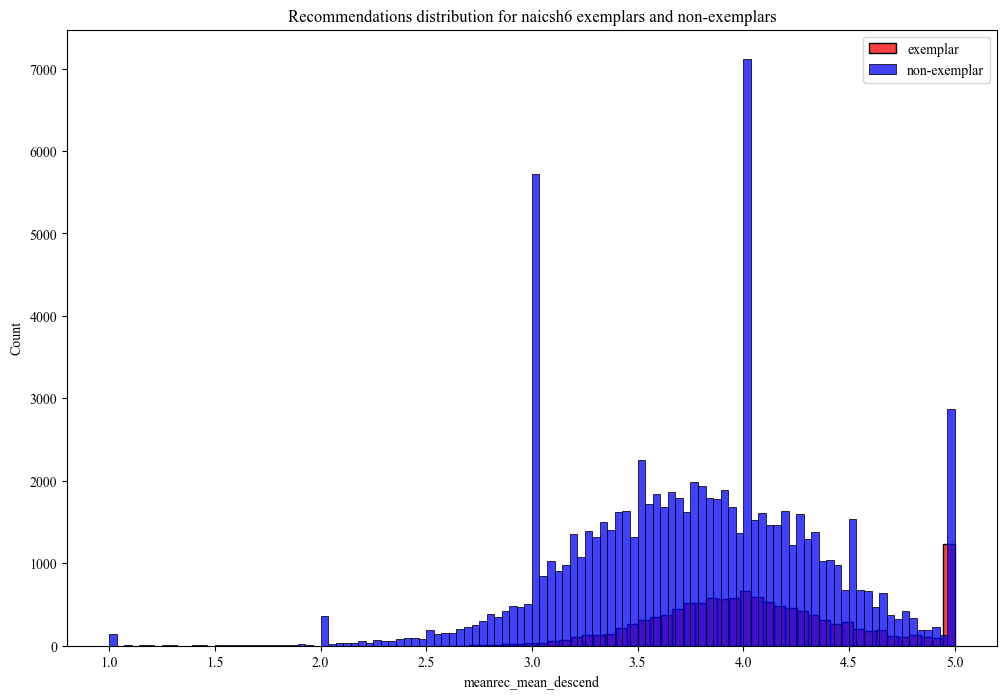

In [18]:
# plot the distribution of numrec_mean_0 for f'exemplar_{ind_col}' == True and False in the same plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=database[database[f'exemplar_{ind_col}']==True], x='meanrec_mean_descend', ax=ax, color='red', label='exemplar')
sns.histplot(data=database[database[f'exemplar_{ind_col}']==False], x='meanrec_mean_descend', ax=ax, color='blue', label='non-exemplar')
ax.legend()
ax.set_title(f'Recommendations distribution for {ind_col} exemplars and non-exemplars')
plt.show()

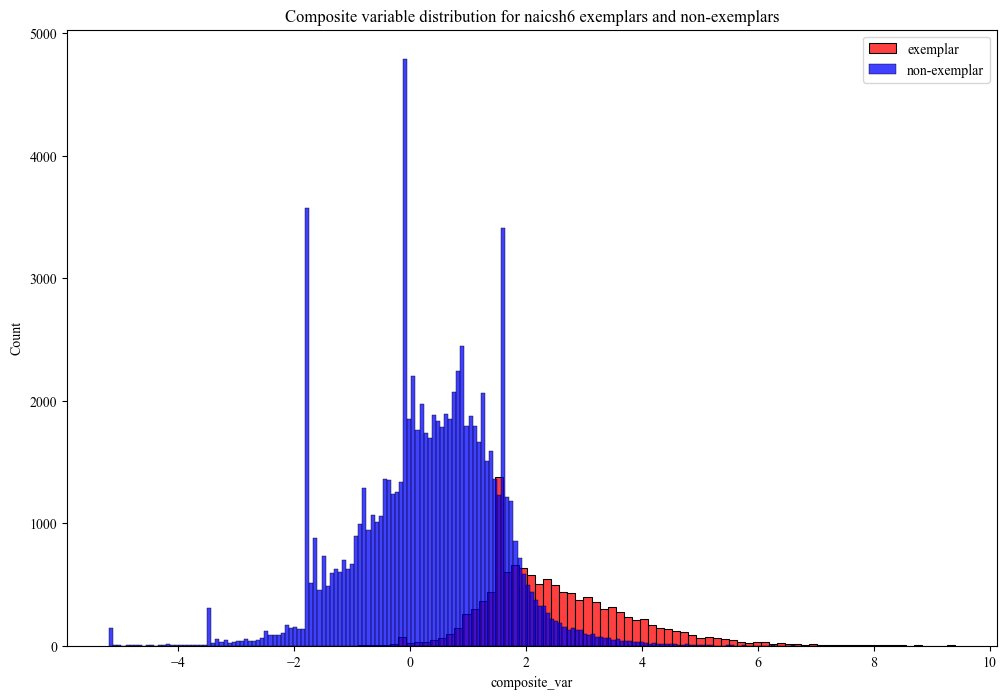

In [19]:
# plot the distribution of numrec_mean_0 for f'exemplar_{ind_col}' == True and False in the same plot
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=database[database[f'exemplar_{ind_col}']==True], x='composite_var', ax=ax, color='red', label='exemplar')
sns.histplot(data=database[database[f'exemplar_{ind_col}']==False], x='composite_var', ax=ax, color='blue', label='non-exemplar')
ax.legend()
ax.set_title(f'Composite variable distribution for {ind_col} exemplars and non-exemplars')
plt.show()

# Measuring Exemplar Similarity

In [20]:

# Adding similarities
score_df = pd.read_pickle(f'../data/NLP/sims_all_{nlp_model}_{str(doc2vec_vector_size)}_{ind_type}.pkl')
score_df = score_df[['score', 'gvkey1', 'gvkey2', 'year']]
score_df = score_df[score_df['gvkey1'] != score_df['gvkey2']]
score_df.set_index(['gvkey1', 'gvkey2', 'year'], inplace=True)


ex_col = 'exemplar_'+ind_col
exemplars = database[['GVKEY',ind_col, 'year', ex_col, ]][
    database[ex_col]==True]
exemplars.columns = ['gvkey2', ind_col, 'year', ex_col]
all_firms = database[['GVKEY', ind_col, 'year']]
all_firms.columns = ['gvkey1', ind_col, 'year']

pairs = pd.merge(all_firms, exemplars, on=[ind_col, 'year'],
                    how='outer')


pairs.gvkey2.dropna(inplace=True)
pairs = pairs[np.isfinite(pairs['gvkey2'])]
print(pairs[np.isfinite(pairs['gvkey2'])].equals(pairs))

pairs.gvkey2 = pairs.gvkey2.astype(int)
pairs.set_index(['gvkey1', 'gvkey2', 'year'], inplace=True)

ex_sim_col = 'exemplar_sim_' + ind_col
score_df.columns=[ex_sim_col]


pairs = pd.merge(pairs, score_df, left_index=True, right_index=True)
pairs.reset_index(inplace=True)
pairs_ids = pairs.groupby(['gvkey1','year'])[ex_sim_col].idxmax()
pairs = pairs.loc[pairs_ids]

ex_col_gvkey = ex_col + "_gvkey"
pairs.columns = ['GVKEY', ex_col_gvkey, 'year', ind_type, f'exemplar_{ind_col}',
        ex_sim_col]
pairs = pairs[['GVKEY',  ex_col_gvkey,'year', ex_sim_col]]

database = pd.merge(database, pairs, on=['GVKEY','year'],
                        how='left')

pairs.drop_duplicates(['GVKEY', 'year'])

True


,GVKEY,exemplar_naicsh6_gvkey,year,exemplar_sim_naicsh6
5,1013,14264,1994,0.845873
10,1013,3705,1995,0.907583
23,1013,10420,1996,0.935600
91,1013,28848,1998,0.905202
221,1013,10420,1999,0.836592
...,...,...,...,...
279282,345556,23407,2021,0.962155
578429,345980,64768,2020,0.885530
578534,345980,64768,2021,0.890343
279330,347007,18562,2021,0.961331


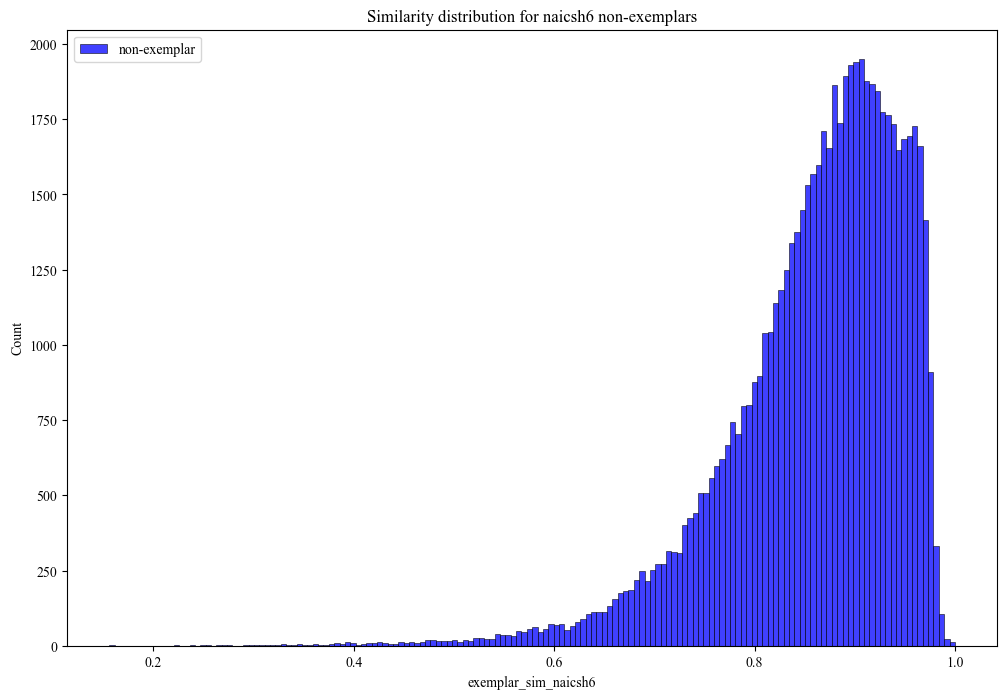

In [21]:
# Plotting f'exemplar_sim_{ind_col}' for firms that are not exemplars (f'exemplar_{ind_col}']==0)
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=database[database[f'exemplar_{ind_col}']==False], x=f'exemplar_sim_{ind_col}', ax=ax, color='blue', label='non-exemplar')
ax.legend()
ax.set_title(f'Similarity distribution for {ind_col} non-exemplars')
plt.show()


# Add the mean similirity to the 5, 10, and 20 firms for each firm

In [22]:

score_df = pd.read_pickle(f'../data/NLP/sims_all_{nlp_model}_{str(doc2vec_vector_size)}_{ind_type}.pkl')

score_df = score_df[['score', 'gvkey1', 'gvkey2', 'year']]
score_df = score_df[score_df['gvkey1'] != score_df['gvkey2']]

sim_5nearest = score_df.sort_values(['gvkey1', 'year', 'score'], ascending=False).groupby(['gvkey1', 'year']).head(5)
sim_5nearest = sim_5nearest.groupby(['gvkey1', 'year'])['score'].mean().reset_index()
sim_5nearest.columns = ['GVKEY', 'year', 'sim_5nearest']

sim_10nearest = score_df.sort_values(['gvkey1', 'year', 'score'], ascending=False).groupby(['gvkey1', 'year']).head(10)
sim_10nearest = sim_10nearest.groupby(['gvkey1', 'year'])['score'].mean().reset_index()
sim_10nearest.columns = ['GVKEY', 'year', 'sim_10nearest']

sim_20nearest = score_df.sort_values(['gvkey1', 'year', 'score'], ascending=False).groupby(['gvkey1', 'year']).head(20)
sim_20nearest = sim_20nearest.groupby(['gvkey1', 'year'])['score'].mean().reset_index()
sim_20nearest.columns = ['GVKEY', 'year', 'sim_20nearest']

database = pd.merge(database, sim_5nearest, on=['GVKEY', 'year'], how='left')
database = pd.merge(database, sim_10nearest, on=['GVKEY', 'year'], how='left')
database = pd.merge(database, sim_20nearest, on=['GVKEY', 'year'], how='left')

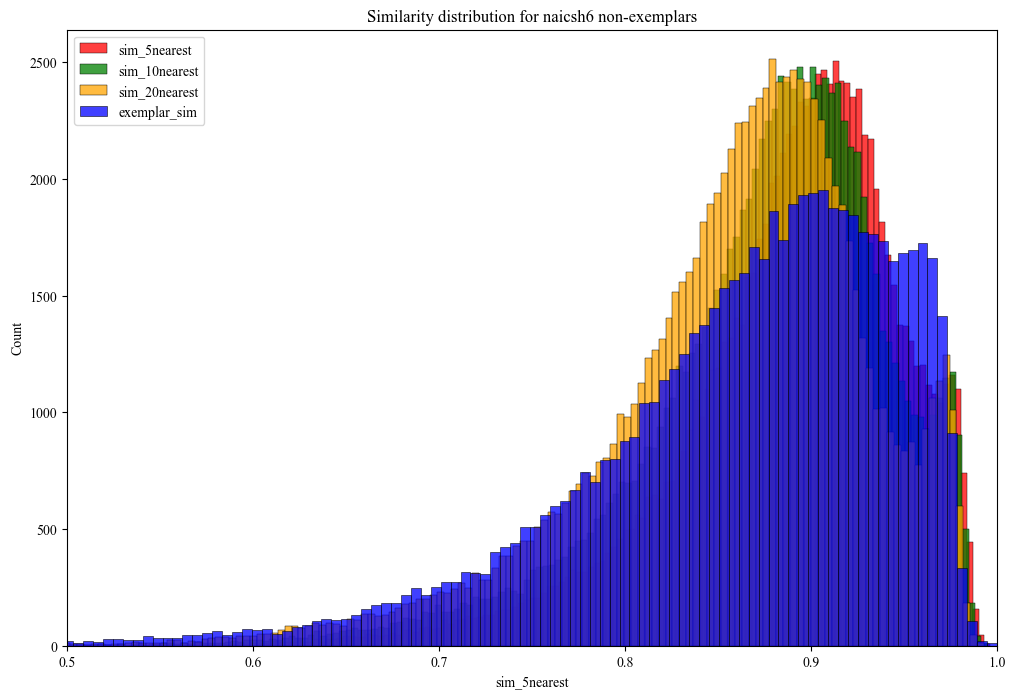

In [23]:
# plot sim_5nearest, sim_10nearest, sim_20nearest and 'exemplar_sim_{ind_col}' for f'exemplar_{ind_col}' == False in the same plot
# limiting the xlim between 0.5 and 1, for visualisation purposes
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=database[database[f'exemplar_{ind_col}']==False], x='sim_5nearest', ax=ax, color='red', label='sim_5nearest')
sns.histplot(data=database[database[f'exemplar_{ind_col}']==False], x='sim_10nearest', ax=ax, color='green', label='sim_10nearest')
sns.histplot(data=database[database[f'exemplar_{ind_col}']==False], x='sim_20nearest', ax=ax, color='orange', label='sim_20nearest')
sns.histplot(data=database[database[f'exemplar_{ind_col}']==False], x='exemplar_sim_'+ind_col, ax=ax, color='blue', label='exemplar_sim')
ax.legend()
ax.set_title(f'Similarity distribution for {ind_col} non-exemplars')
ax.set_xlim(0.5, 1)
plt.show()

(0.5, 1.0)

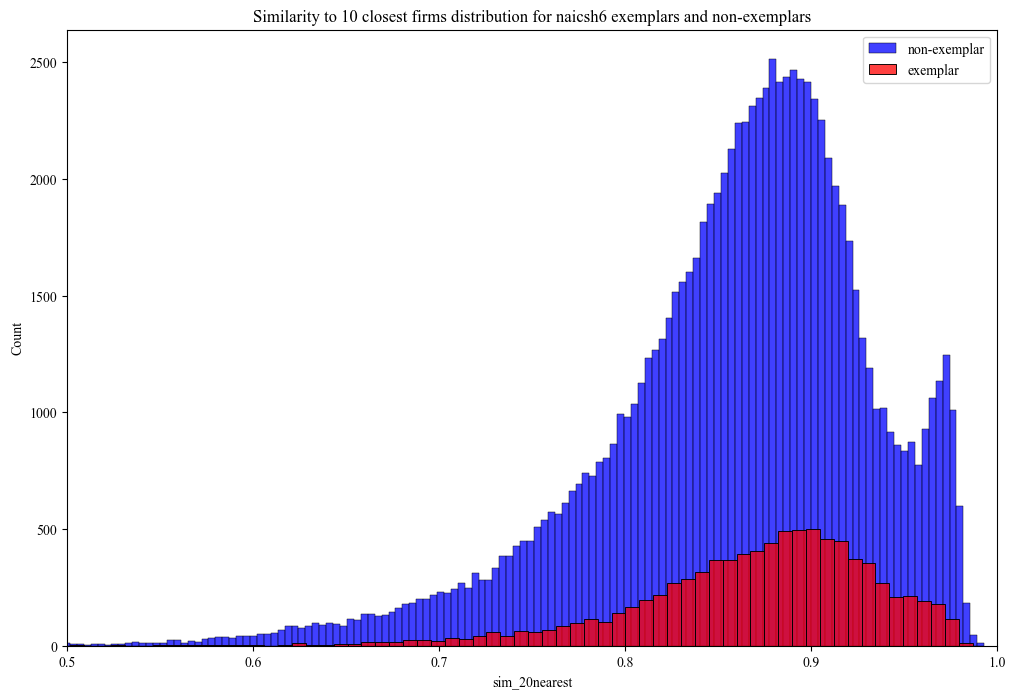

In [24]:
# plot sim_10nearest for f'exemplar_{ind_col}' == True and f'exemplar_{ind_col}' == False in the same plot
# limiting the xlim between 0.5 and 1, for visualisation purposes
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=database[database[f'exemplar_{ind_col}']==False], x='sim_20nearest', ax=ax, color='blue', label='non-exemplar')
sns.histplot(data=database[database[f'exemplar_{ind_col}']==True], x='sim_20nearest', ax=ax, color='red', label='exemplar')
ax.legend()
ax.set_title(f'Similarity to 10 closest firms distribution for {ind_col} exemplars and non-exemplars')
ax.set_xlim(0.5, 1)

# Category Average Vector

In [25]:


# Measuring similarity between any two firms in same sic2 code
wrds_index = pd.read_csv(f'../data/WRDS_SEC_1994_2022_gvkey_{filing_source}.csv')
wrds_index = wrds_index[['GVKEY', 'datadate', 'year', ind_col, 'id']]

# keep only wrds_index where id is availabe in doc_vectors index
wrds_index = wrds_index[wrds_index['id'].isin(doc_vectors.index)]
wrds_index['datadate'] = pd.to_datetime(wrds_index['datadate'])

industry_vecs = dict()
industry_vecs_indice = dict()

for ind_code in [ind_col]:
    # get the unique industries and years for this naics code level
    ind_year = wrds_index.groupby(['year', ind_code]).head()[[ind_code, 'year']]
    ind_year_list  = ind_year.values.tolist()

    # initialize an empty numpy array to store the industry vectors
    num_columns = doc_vectors.shape[1]
    ind_vecs = np.zeros((len(ind_year_list), num_columns))
    ind_vecs_indice = np.zeros((len(ind_year_list), 2))

    # get average vector for each industry by year using groupby
    # the result is a numpy array of shape (num_years*num_industries, vector_size)
    for i, ind in enumerate(ind_year_list):
        ind_vecs[i] = np.mean(doc_vectors.loc[wrds_index.loc[(wrds_index[ind_code] == ind[0]) & (wrds_index['year'] == ind[1])]['id']], axis=0)
        ind_vecs_indice[i] = ind

    industry_vecs[ind_code] = ind_vecs
    industry_vecs_indice[ind_code] = ind_year_list

In [26]:
industry_vecs[ind_code]

array([[-0.00606277,  0.01525887, -0.00453763, ..., -0.00800629,
        -0.02033009, -0.01569829],
       [-0.00472871,  0.01522901, -0.00512953, ..., -0.00611904,
        -0.01886621, -0.01560326],
       [-0.00490016,  0.01456317, -0.00447136, ..., -0.00665209,
        -0.01862891, -0.01540524],
       ...,
       [ 0.04079676,  0.02973464, -0.0149298 , ...,  0.00947474,
        -0.01031062, -0.01971629],
       [ 0.01142326,  0.02212055, -0.02496253, ...,  0.00082666,
        -0.00477894, -0.00727509],
       [ 0.02175554,  0.02466718, -0.02365907, ...,  0.00052843,
        -0.01743605, -0.02472737]])

# Firm Typicality

In [27]:

ind_code = ind_col

# get the industry average vector for each firm in wrds_index
# the result is a numpy array of shape (num_firms, vector_size)
ind_vecs = industry_vecs[ind_code]
ind_vecs_indice = industry_vecs_indice[ind_code]

# for each firm, get the industry average vector for the same year and naics code level
# use the industry_vecs_indice dictionary to get the indices of the industry average vectors
# then get the industry vector from ind_vecs
# the result is a numpy array of shape (num_firms, vector_size)
firm_ind_vecs = np.zeros((len(wrds_index), doc_vectors.shape[1]))
for i in range(len(wrds_index)):
    ind_year = [wrds_index[ind_code].iloc[i], wrds_index['year'].iloc[i]]
    # if the industry average vector for this year and naics code level is not available, return np.nan for this firm
    if ind_year not in ind_vecs_indice:
        firm_ind_vecs[i] = np.nan
        continue
    ind_vecs_indice.index(ind_year)
    firm_ind_vecs[i] = ind_vecs[ind_vecs_indice.index(ind_year)]


# get the document vectors for each firm in wrds_index
# the result is a numpy array of shape (num_firms, vector_size)
doc_vecs = doc_vectors.loc[wrds_index['id'].values]

# calculate the similarity between each firm and its industry average vector
# the result is a numpy array of shape (num_firms, )
sim_mean = np.zeros(len(wrds_index))
for i in range(len(wrds_index)):
    # if the industry average vector for this year and naics code level is not available, return np.nan for this firm
    if np.isnan(firm_ind_vecs[i]).any():
        sim_mean[i] = np.nan
        continue
    sim_mean[i] = cosine_similarity(doc_vecs.iloc[i].values.reshape(1, -1), firm_ind_vecs[i].reshape(1, -1))[0][0]

# add a column to wrds_index with the similarity values
wrds_index['sim_mean_' + ind_code] = sim_mean

In [28]:
firm_typicality = wrds_index[['GVKEY', 'datadate', f'sim_mean_{ind_code}']]
database2 = pd.merge(database, firm_typicality,
                        on=['GVKEY', 'datadate'], how='left')

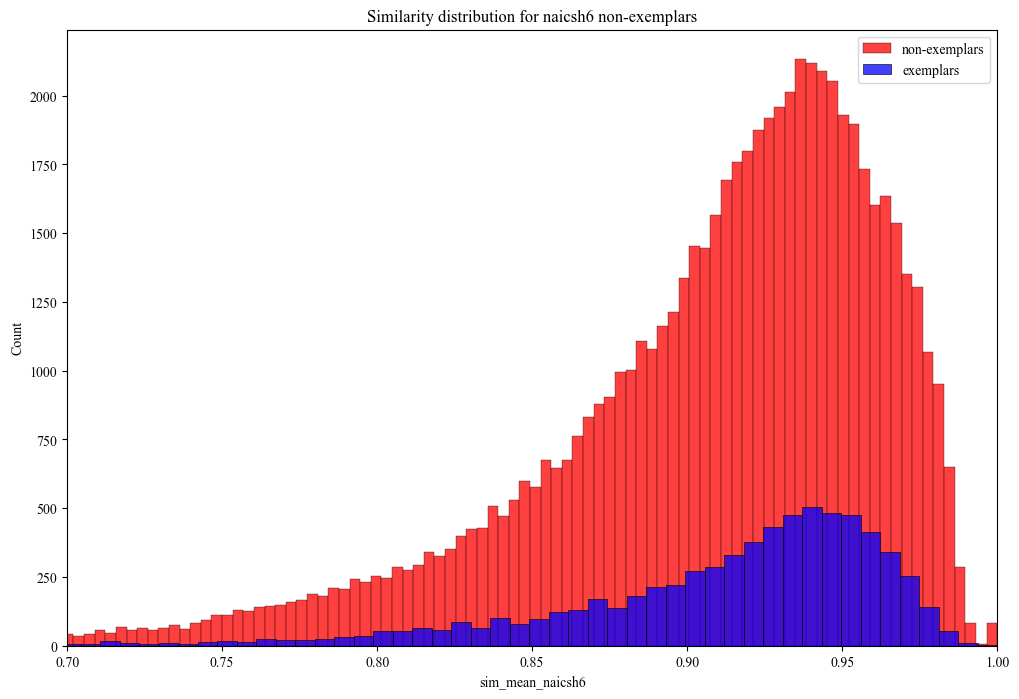

In [29]:
# Plotting the distribution of f'sim_mean_{ind_code}' for f'exemplar_{ind_col}']==False and True in the same plot
# limiting the xlim between 0.5 and 1, for visualisation purposes
# limiting to industries with at least 10 firms
database2['num_firms'] = database2.groupby([ind_col, 'year'])['GVKEY'].transform('count')

fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=database2[(database2[f'exemplar_{ind_col}']==False) & (database2['num_firms']>=10)], x=f'sim_mean_{ind_code}', ax=ax, color='red', label='non-exemplars')
sns.histplot(data=database2[(database2[f'exemplar_{ind_col}']==True) & (database2['num_firms']>=10)], x=f'sim_mean_{ind_code}', ax=ax, color='blue', label='exemplars')
ax.legend()
ax.set_title(f'Similarity distribution for {ind_code} non-exemplars')
ax.set_xlim(0.7, 1)
plt.show()

del database2['num_firms']



# Exemplar Typicality

In [30]:

database2 = pd.merge(database, firm_typicality,
                        on=['GVKEY', 'datadate'], how='left')

database2[database2[f'exemplar_{ind_col}']==1][f'sim_mean_{ind_code}'].mean()

exemplar_gvkey_col = 'exemplar_' + ind_col + '_gvkey'
exemplar_typicality_col = 'exemplar_' + ind_col + '_typicality'
sim_mean_col = 'sim_mean_' + ind_col

exemplars_df = database2[['GVKEY', sim_mean_col, 'year']]
exemplars_df.columns  = [exemplar_gvkey_col, exemplar_typicality_col, 'year']

database2 = pd.merge(database2, exemplars_df,
                            on = [exemplar_gvkey_col,  'year'], how='left')



# Category Coherence


In [31]:
database2[f'category_coherence_{ind_col}'] = database2.groupby([ind_col,'year'])[f'sim_mean_{ind_code}'].transform('mean')

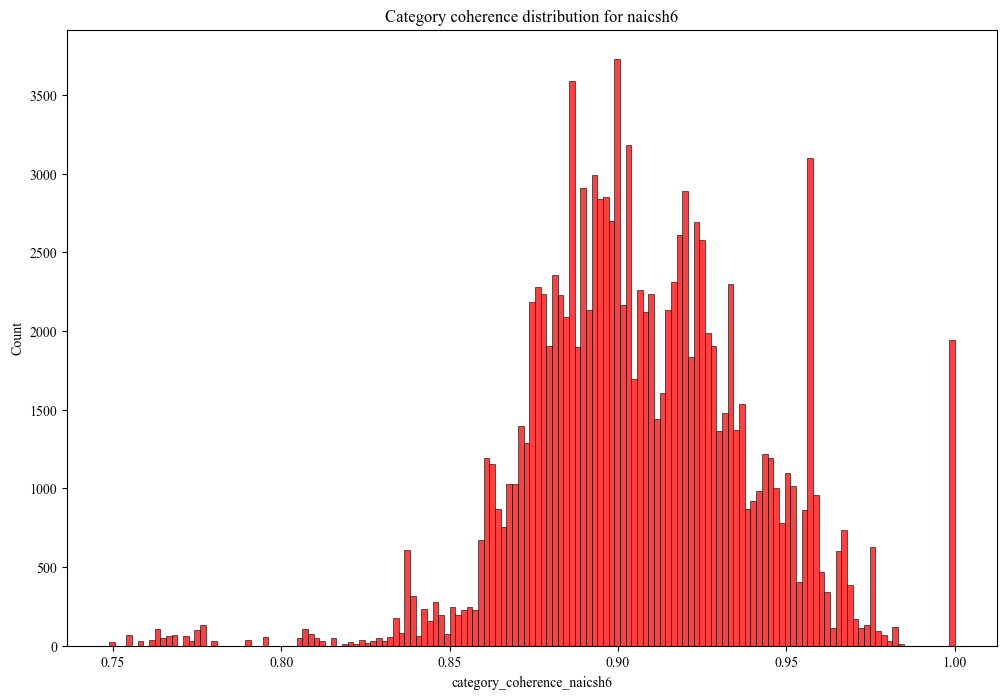

In [32]:
# Plotting the distribution of category coherence, grouping by ind_col and year
# limiting to industries with at least 10 firms
database2['num_firms'] = database2.groupby([ind_col, 'year'])['GVKEY'].transform('count')

fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=database2[database2['num_firms']>=10], x=f'category_coherence_{ind_col}', ax=ax, color='red')
ax.set_title(f'Category coherence distribution for {ind_code}')
plt.show()


In [33]:

# 9- Category Distinctiveness
ind_code = ind_col
print(ind_code)
industry_vec = industry_vecs[ind_code]
industry_vecs_index = industry_vecs_indice[ind_code]


df = pd.DataFrame(industry_vecs_index, columns=[ind_code,'year'])
df = df.reset_index().rename(columns={'index':'index_vectors'})
df.columns

df[ind_dist_level] = df[ind_code].astype(str).str.replace('.', '').str[:2].astype(int)

if ind_code == 'naicsh4' and ind_dist_level == 'naicsh2':
    df[ind_dist_level] = df[ind_code].astype(str).str.replace('.', '').str[:2].astype(int)
elif ind_code == 'naicsh5' and ind_dist_level == 'naicsh2':
    df[ind_dist_level] = df[ind_code].astype(str).str.replace('.', '').str[:2].astype(int)
elif ind_code == 'naicsh6' and ind_dist_level == 'naicsh2':
    df[ind_dist_level] = df[ind_code].astype(str).str.replace('.', '').str[:2].astype(int)
elif ind_code == 'naicsh3' and ind_dist_level == 'naicsh2':
    df[ind_dist_level] = df[ind_code].astype(str).str.replace('.', '').str[:2].astype(int)
elif ind_code == 'sich4' and ind_dist_level == 'sich2':
    df[ind_dist_level] = df[ind_code].astype(str).str.replace('.', '').str[:2].astype(int)
elif ind_code == 'sich3' and ind_dist_level == 'sich2':
    df[ind_dist_level] = df[ind_code].astype(str).str.replace('.', '').str[:2].astype(int)


if ind_dist_level != ind_code:
    # Merge the data frame with itself on the 'year' column
    df = pd.merge(df, df, on=['year', ind_dist_level], how='outer')
    df = df[df[ind_code+"_x"]!=df[ind_code+"_y"]]

else:
    df = pd.merge(df, df, on=['year'], how='outer')

# Get the indices of the rows to compare
indices = df[['index_vectors'+"_x", 'index_vectors'+"_y"]].values


# new sim function
chunk_size = 100000  # Size of chunks
num_chunks = len(indices) // chunk_size + 1

cosine_similarities = np.zeros(len(indices))
for chunk_idx in range(num_chunks):
    start_idx = chunk_idx * chunk_size
    end_idx = min((chunk_idx + 1) * chunk_size, len(indices))

    vectors1 = industry_vec[indices[start_idx:end_idx, 0]]
    vectors2 = industry_vec[indices[start_idx:end_idx, 1]]

    dot_products = np.einsum('ij,ij->i', vectors1, vectors2)
    norms = np.linalg.norm(vectors1, axis=1) * np.linalg.norm(vectors2, axis=1)
    cosine_similarities[start_idx:end_idx] = dot_products / norms

    print(f'Chunk {chunk_idx + 1} out of {num_chunks} done')

df['sims'] = cosine_similarities
df = df.groupby([ind_code+'_x','year'])['sims'].mean().reset_index()
ind_dist_col = 'ind_sim_all_' + ind_code
df.columns = [ind_code, 'year', ind_dist_col]

df.columns

# merge industry heterogeneity data with wrds_index
database2 = pd.merge(database2, df, how='left',
                        left_on=['year', ind_code], right_on=['year', ind_code])


database2[f'ind_sim_all_{ind_col}_distinct'] = -1 * database2[f'ind_sim_all_{ind_col}']

naicsh6
Chunk 1 out of 85 done
Chunk 2 out of 85 done
Chunk 3 out of 85 done
Chunk 4 out of 85 done
Chunk 5 out of 85 done
Chunk 6 out of 85 done
Chunk 7 out of 85 done
Chunk 8 out of 85 done
Chunk 9 out of 85 done
Chunk 10 out of 85 done
Chunk 11 out of 85 done
Chunk 12 out of 85 done
Chunk 13 out of 85 done
Chunk 14 out of 85 done
Chunk 15 out of 85 done
Chunk 16 out of 85 done
Chunk 17 out of 85 done
Chunk 18 out of 85 done
Chunk 19 out of 85 done
Chunk 20 out of 85 done
Chunk 21 out of 85 done
Chunk 22 out of 85 done
Chunk 23 out of 85 done
Chunk 24 out of 85 done
Chunk 25 out of 85 done
Chunk 26 out of 85 done
Chunk 27 out of 85 done
Chunk 28 out of 85 done
Chunk 29 out of 85 done
Chunk 30 out of 85 done
Chunk 31 out of 85 done
Chunk 32 out of 85 done
Chunk 33 out of 85 done
Chunk 34 out of 85 done
Chunk 35 out of 85 done
Chunk 36 out of 85 done
Chunk 37 out of 85 done
Chunk 38 out of 85 done
Chunk 39 out of 85 done
Chunk 40 out of 85 done
Chunk 41 out of 85 done
Chunk 42 out of 8

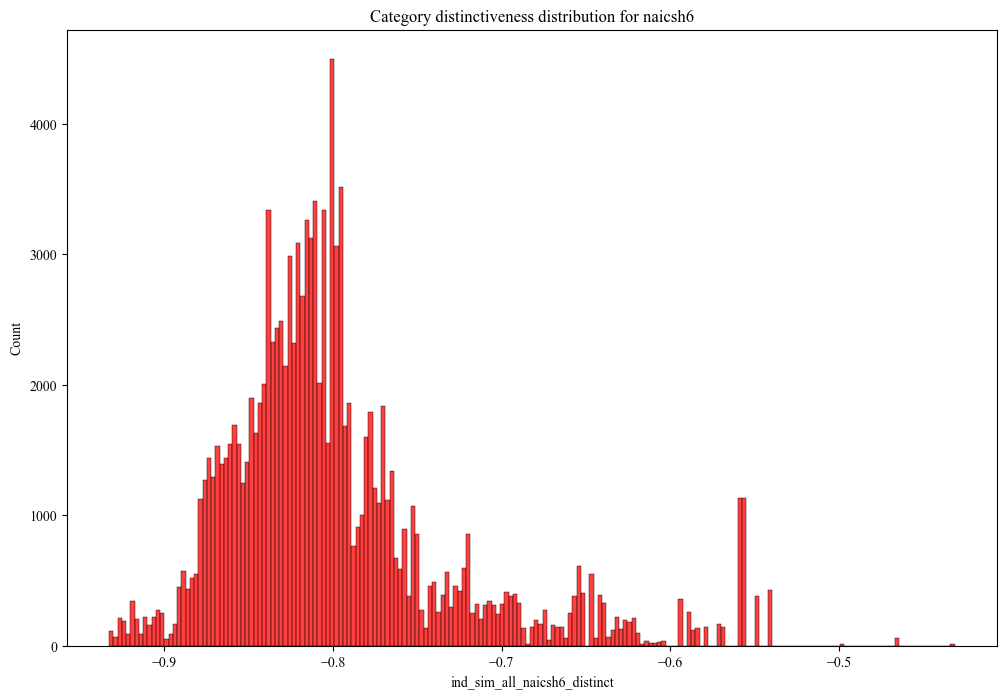

In [34]:
# plot the distribution of f'ind_sim_all_{ind_col}_distinct' for ind_col years, limiting to industries with at least 10 firms
database2['num_firms'] = database2.groupby([ind_col, 'year'])['GVKEY'].transform('count')

fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=database2[database2['num_firms']>=10], x=f'ind_sim_all_{ind_col}_distinct', ax=ax, color='red')
ax.set_title(f'Category distinctiveness distribution for {ind_code}')
plt.show()


# Category Instability


In [35]:
ind_code = ind_col

# get the industry vectors and indices for this naics code level
ind_vecs = industry_vecs[ind_code]
ind_vecs_indice = industry_vecs_indice[ind_code]

# transform indices to a dataframe
ind_vecs_indice = pd.DataFrame(ind_vecs_indice, columns=[ind_code, 'year'])

# reset index to be the industry vector index
ind_vecs_indice.reset_index(inplace=True)
# rename the index column to be the industry vector index
ind_vecs_indice.rename(columns={'index': 'ind_vec_index'}, inplace=True)

# sort by industry and year
ind_vecs_indice.sort_values(by=[ind_code, 'year'], inplace=True)

# find previous year's industry vector index, if the industry is the same and there is only one year difference
ind_vecs_indice['prev_ind_vec_index'] = ind_vecs_indice.groupby([ind_code])['ind_vec_index'].shift(1)
ind_vecs_indice['prev_year'] = ind_vecs_indice.groupby([ind_code])['year'].shift(1)
ind_vecs_indice = ind_vecs_indice[ind_vecs_indice['year'] - ind_vecs_indice['prev_year'] == 1]

# calculate cosine similarity between each industry and the previous year's industry
ind_vecs_indice['cosine_sim'] = ind_vecs_indice.apply(lambda x: cosine_similarity(ind_vecs[int(x['ind_vec_index'])].reshape(1, -1), ind_vecs[int(x['prev_ind_vec_index'])].reshape(1, -1))[0][0], axis=1)


ind_vecs_indice = ind_vecs_indice[[ind_code, 'year', 'cosine_sim']]
ind_vecs_indice['cosine_sim'] = 1-ind_vecs_indice['cosine_sim']
col_name = "ind_vecs_change_" + ind_code
ind_vecs_indice.columns = [ind_code, 'year', col_name]

database2 = pd.merge(database2, ind_vecs_indice, on=[ind_code, 'year'],
                        how='left')

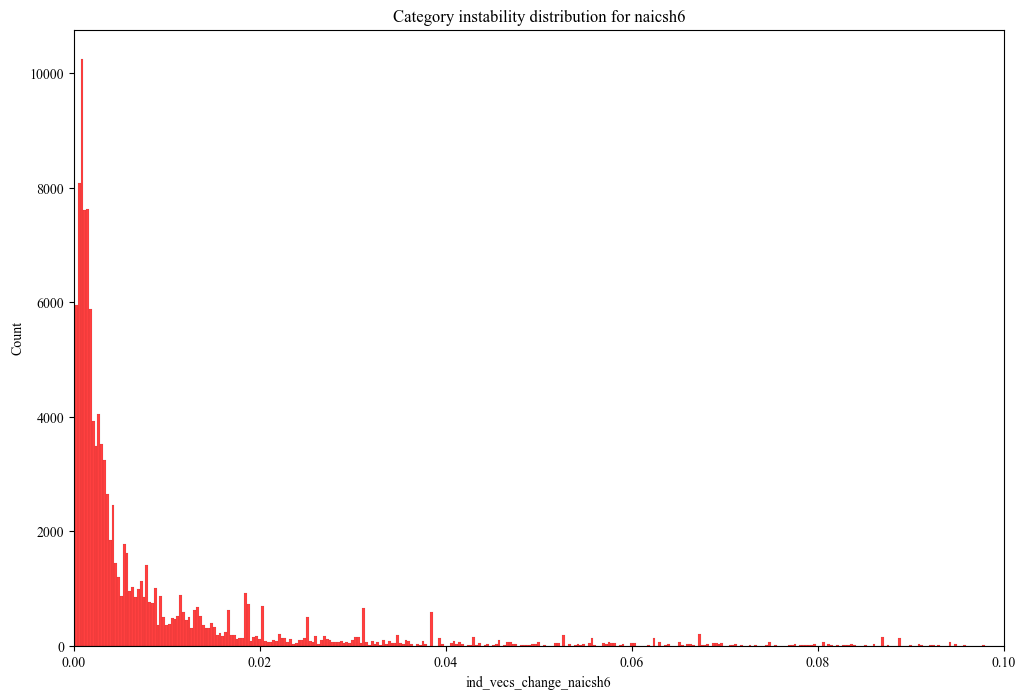

In [36]:
# plotting the distribution of ind_vecs_change_{ind_col} for ind_col years, limiting to industries with at least 10 firms
# limiting xlim to 0 0.1 to see the distribution better
database2['num_firms'] = database2.groupby([ind_col, 'year'])['GVKEY'].transform('count')

fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=database2[database2['num_firms']>=10], x=col_name, ax=ax, color='red')
ax.set_title(f'Category instability distribution for {ind_code}')
plt.xlim(0, 0.1)
plt.show()

# Saving the data


In [81]:
database2 = database2[['GVKEY', 'year',  'meanrec', 'numrec', 'meanrec_mean', 'numrec_mean', 'meanrec_descend',
       'meanrec_mean_descend', 'numrec_mean_0', 'composite_var',
       f'exemplar_{ind_col}', f'exemplar_{ind_col}_gvkey', f'exemplar_sim_{ind_col}',
       f'sim_mean_{ind_col}', f'exemplar_{ind_col}_typicality',
       f'category_coherence_{ind_col}', f'ind_vecs_change_{ind_col}', f'ind_sim_all_{ind_col}_distinct',
                       'sim_5nearest', 'sim_10nearest', 'sim_20nearest']]


database2.to_pickle(f'../data/NLP/10k_vars_{nlp_model}_{str(doc2vec_vector_size)}_{ind_col}.pkl')


# Descriptives and Data Exploration

In [3]:
database2 = pd.read_pickle(f'../data/NLP/10k_vars_{nlp_model}_{str(doc2vec_vector_size)}_{ind_col}.pkl')


### Adding NAICS code descriptions

In [6]:
# Measuring similarity between any two firms in same sic2 code
wrds_index = pd.read_csv(f'../data/WRDS_SEC_1994_2022_gvkey_{filing_source}.csv')

# keep only wrds_index where id is availabe in doc_vectors index
wrds_index = wrds_index[wrds_index['id'].isin(doc_vectors.index)]

# merge wrds_index with database2 on GVKEY and year
wrds_index = pd.merge(wrds_index, database2, on=['GVKEY', 'year'], how='left', suffixes=('', '_y'))
wrds_index['no_firms_ind'] = wrds_index.groupby([ind_col, 'year'])['GVKEY'].transform('count')

In [7]:
wrds_index.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'fdate', 'cik', 'findexdate',
       'lindexdate', 'form', 'coname', 'wrdsfname', 'fsize', 'doccount',
       'fname', 'rdate', 'secadate', 'secatime', 'secpdate', 'accession',
       'regcount', 'regseq', 'regrole', 'regcik', 'regfile_no', 'regfilm_no',
       'regconame', 'regfye', 'regsic', 'regstreet_hdq', 'regcity_hdq',
       'regstate_hdq', 'regzip_hdq', 'regstate_inc', 'regphone', 'regfconame',
       'regfchangedate', 'regirs', 'url', 'id', 'GVKEY', 'datadate', 'year',
       'month', 'cusip_8', 'conm', 'sich', 'naicsh', 'naicsh6', 'naicsh5',
       'naicsh4', 'naicsh3', 'naicsh2', 'delta', 'meanrec', 'numrec',
       'meanrec_mean', 'numrec_mean', 'meanrec_descend',
       'meanrec_mean_descend', 'numrec_mean_0', 'composite_var',
       'exemplar_naicsh6', 'exemplar_naicsh6_gvkey', 'exemplar_sim_naicsh6',
       'sim_mean_naicsh6', 'exemplar_naicsh6_typicality',
       'category_coherence_naicsh6', 'ind_vecs_change_naicsh6',
       'ind_si

In [8]:
# Download NAICS codes
# from this link: https://www.census.gov/naics/2022NAICS/2-6%20digit_2022_Codes.xlsx
previously_downloaded_naics_codes = True

if previously_downloaded_naics_codes == False:
    url = 'https://www.census.gov/naics/2022NAICS/2-6%20digit_2022_Codes.xlsx'
    naics_codes = pd.read_excel(url)
    naics_codes.to_csv('../data/naics_codes.csv', index=False)
else:
    naics_codes = pd.read_csv('../data/naics_codes.csv')

In [9]:
naics_codes.columns

Index(['Seq. No.', '2022 NAICS US   Code', '2022 NAICS US Title', 'Unnamed: 3',
       'Unnamed: 4'],
      dtype='object')

In [10]:
naics_codes = naics_codes[['2022 NAICS US   Code', '2022 NAICS US Title']]
naics_codes.rename(columns={'2022 NAICS US   Code': 'naics_code', '2022 NAICS US Title': 'naics_title'}, inplace=True)
naics_codes.dropna(inplace=True)


In [11]:
# if naics code is x-y, keep only x
naics_codes['naics_code'] = naics_codes['naics_code'].apply(lambda x: x.split('-')[0])


In [12]:
naics_codes['naics_code'] = naics_codes['naics_code'].astype(str)


In [13]:
# Define the custom padding function
def custom_pad(code):
    return code + '0' * (6 - len(code))

# Apply the custom function
naics_codes['naics_code'] = naics_codes['naics_code'].apply(custom_pad)

In [14]:
naics_codes['naics_code'] = naics_codes['naics_code'].astype(int)

In [15]:
naics_codes.drop_duplicates(inplace=True)

In [16]:
naics_codes.drop_duplicates(subset = ['naics_code'],inplace=True)

In [17]:
wrds_index = pd.merge(wrds_index, naics_codes, left_on=ind_col, right_on='naics_code', how='left')

In [18]:
wrds_index[['GVKEY','year', ind_col, 'naics_title']]

,GVKEY,year,naicsh6,naics_title
0,16609.0,1995.0,524126.0,Direct Property and Casualty Insurance Carriers
1,16609.0,1996.0,524126.0,Direct Property and Casualty Insurance Carriers
2,16609.0,1997.0,524126.0,Direct Property and Casualty Insurance Carriers
3,16609.0,1998.0,524126.0,Direct Property and Casualty Insurance Carriers
4,1094.0,2000.0,422690.0,NaN
...,...,...,...,...
105579,39811.0,2021.0,336111.0,NaN
105580,38288.0,2021.0,721000.0,Accommodation
105581,39820.0,2021.0,442110.0,NaN
105582,40417.0,2021.0,531210.0,Offices of Real Estate Agents and Brokers


## List of exemplars by industry in 2015

In [19]:
exemplars = wrds_index[wrds_index[f'exemplar_{ind_col}']==1]

In [20]:
exemplars = exemplars[exemplars['year']==2015]

In [21]:
exemplars = exemplars[['GVKEY', 'coname', ind_col, 'naics_title', 'numrec_mean', 'meanrec_mean_descend', f'sim_mean_{ind_col}']]

In [22]:
exemplars

,GVKEY,coname,naicsh6,naics_title,numrec_mean,meanrec_mean_descend,sim_mean_naicsh6
305,1327.0,"SKYWORKS SOLUTIONS, INC.",334413.0,Semiconductor and Related Device Manufacturing,22.454545,4.157273,0.952857
419,1440.0,AMERICAN ELECTRIC POWER CO INC,221100.0,"Electric Power Generation, Transmission and Di...",21.363636,3.784545,0.940704
616,1632.0,ANALOG DEVICES INC,334413.0,Semiconductor and Related Device Manufacturing,29.090909,3.705455,0.949819
756,1704.0,APPLIED MATERIALS INC /DE,333242.0,Semiconductor Machinery Manufacturing,22.090909,3.956364,0.890453
861,9904.0,SOUTHWESTERN ENERGY CO,211111.0,NaN,36.454545,3.423636,0.952623
...,...,...,...,...,...,...,...
104285,20655.0,"NextEra Energy Partners, LP",221100.0,"Electric Power Generation, Transmission and Di...",15.727273,3.840909,0.833382
104318,64853.0,"Qorvo, Inc.",334413.0,Semiconductor and Related Device Manufacturing,17.545455,4.121818,0.953554
104410,7228.0,Medtronic plc,334510.0,"Navigational, Measuring, Electromedical, and C...",22.700000,4.032000,0.953992
104693,24616.0,"PayPal Holdings, Inc.",518210.0,"Computing Infrastructure Providers, Data Proce...",28.000000,3.831667,0.843151


In [141]:
exemplars.to_csv(f'../data/tables/exemplars_{ind_col}_2015.csv', index=False)

## Exemplars with different typicalities

In [45]:
wrds_index.dropna(subset=[f'sim_mean_{ind_col}'])[wrds_index[f'exemplar_{ind_col}']==1][f'sim_mean_{ind_col}'].mean()

0.915323781784296

In [46]:
wrds_index.dropna(subset=[f'sim_mean_{ind_col}'])[wrds_index[f'exemplar_{ind_col}']==0][f'sim_mean_{ind_col}'].mean()

0.9192241829526864

# Some Data Visualizations

### Use the embedding vectors in doc_vectors to create a 3D representation of the documents. Select a random sample of 100 firms in 2020.

In [47]:
# Reduce dimensions with PCA
pca = PCA(n_components=3)
reduced_vectors = pca.fit_transform(doc_vectors.values)

In [48]:

# Convert the numpy array back to a pandas dataframe
reduced_vectors = pd.DataFrame(reduced_vectors, index=doc_vectors.index, columns=["Dimension 1", "Dimension 2", "Dimension 3"])

# Merge the reduced_vectors dataframe with wrds_index using 'id' as the common identifier
merged_df = wrds_index.merge(reduced_vectors, left_on='id', right_index=True)

In [51]:

# Take a random sample of 100 firms
sample_df = merged_df[merged_df['year']==2020].sample(500)

In [52]:
fig = px.scatter_3d(sample_df, x='Dimension 1', y='Dimension 2', z='Dimension 3', 
                     color='Dimension 1', opacity=0.7, hover_data=['GVKEY', f'exemplar_{ind_col}'])
fig.update_traces(marker=dict(size=5))
fig.show()

In [52]:
import plotly.graph_objects as go

sample_exemplars = sample_df[sample_df['exemplar_naicsh6'] == True]
sample_non_exemplars = sample_df[sample_df['exemplar_naicsh6'] == False]

# Create two traces, one for exemplar_naics6==True, one for exemplar_naics6==False
trace1 = go.Scatter3d(
    x=sample_exemplars['Dimension 1'],
    y=sample_exemplars['Dimension 2'],
    z=sample_exemplars['Dimension 3'],
    mode='markers',
    hovertext=sample_exemplars['coname'],
    marker=dict(
        size=6,
        color='red',                # set color to an array/list of desired values
        opacity=0.8
    ),
    name='exemplar_naicsh6=True'
)

trace2 = go.Scatter3d(
    x=sample_non_exemplars['Dimension 1'],
    y=sample_non_exemplars['Dimension 2'],
    z=sample_non_exemplars['Dimension 3'],
    mode='markers',
    hovertext=sample_non_exemplars['coname'],
    marker=dict(
        size=4,
        color='blue',                # set color to an array/list of desired values
        opacity=0.6
    ),
    name='exemplar_naicsh6=False'
)

data = [trace1, trace2]
layout = go.Layout(
    title = '3D Scatter plot',
    scene = dict(
            xaxis = dict(title  = 'Dimension 1'),
            yaxis = dict(title  = 'Dimension 2'),
            zaxis = dict(title  = 'Dimension 3')
        )
)
fig = go.Figure(data=data, layout=layout)
fig.show()


## Plotting 9 industries with various levels of category coherence

In [53]:
merged_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'fdate', 'cik', 'findexdate',
       'lindexdate', 'form', 'coname', 'wrdsfname', 'fsize', 'doccount',
       'fname', 'rdate', 'secadate', 'secatime', 'secpdate', 'accession',
       'regcount', 'regseq', 'regrole', 'regcik', 'regfile_no', 'regfilm_no',
       'regconame', 'regfye', 'regsic', 'regstreet_hdq', 'regcity_hdq',
       'regstate_hdq', 'regzip_hdq', 'regstate_inc', 'regphone', 'regfconame',
       'regfchangedate', 'regirs', 'url', 'id', 'GVKEY', 'datadate', 'year',
       'month', 'cusip_8', 'conm', 'sich', 'naicsh', 'naicsh6', 'naicsh5',
       'naicsh4', 'naicsh3', 'naicsh2', 'delta', 'datadate_y', 'naicsh6_y',
       'month_y', 'cusip_8_y', 'meanrec', 'numrec', 'cusip', 'meanrec_mean',
       'numrec_mean', 'meanrec_descend', 'meanrec_mean_descend',
       'numrec_mean_0', 'composite_var', 'temp_std', 'temp_mean',
       'exemplar_naicsh6', 'exemplar_naicsh6_gvkey', 'exemplar_sim_naicsh6',
       'sim_5nearest', 'sim_10nearest', 'sim

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [177]:
# Limit to year 2020
df_2020 = merged_df[merged_df['year']>1997]

# Limit to industries with at least 50 firms in them
df_50_firms = df_2020[df_2020['no_firms_ind'] >= 50]


In [178]:

# Split the max and min value of coherence into 3 sections
min_coherence = df_50_firms['category_coherence_naicsh6'].min()
max_coherence = df_50_firms['category_coherence_naicsh6'].max()
bins = np.linspace(min_coherence, max_coherence, 9)


In [179]:
bins

array([0.83438711, 0.85136528, 0.86834344, 0.88532161, 0.90229978,
       0.91927794, 0.93625611, 0.95323428, 0.97021244])

In [189]:
# Select one industry from each bin
industries = []
for i in range(len(bins)-1):
    try:
        selection = df_50_firms[(df_50_firms['category_coherence_naicsh6'] > bins[i]) & (df_50_firms['category_coherence_naicsh6'] <= bins[i+1])][['naicsh6', 'year']].dropna()
        
        if not selection.empty:
            unique_values = selection.drop_duplicates()
            
            if not unique_values.empty:
                industry = unique_values.iloc[0]  # Get the first row
                industries.append(industry)
    except Exception as e:
        print(f"An error occurred: {e}")

In [190]:
industries

[naicsh6    518111.0
 year         2006.0
 Name: 23937, dtype: float64,
 naicsh6    334119.0
 year         2001.0
 Name: 287, dtype: float64,
 naicsh6    334413.0
 year         2001.0
 Name: 88, dtype: float64,
 naicsh6    334413.0
 year         2015.0
 Name: 80, dtype: float64,
 naicsh6    334413.0
 year         1998.0
 Name: 91, dtype: float64,
 naicsh6    211111.0
 year         2017.0
 Name: 241, dtype: float64,
 naicsh6    524126.0
 year         1998.0
 Name: 3, dtype: float64,
 naicsh6    522110.0
 year         2015.0
 Name: 924, dtype: float64]

In [194]:
industries = [industries[0], industries[int((len(industries)/2))], industries[len(industries)-1]]

In [195]:

# Select 50 firms in each industry randomly
selected_firms = []
for industry in industries:
    print(industry)
    firms = df_50_firms[(df_50_firms['naicsh6'] == industry['naicsh6']) & (df_50_firms['year'] == industry['year'])]
    selected_firms.append(firms)


naicsh6    518111.0
year         2006.0
Name: 23937, dtype: float64
naicsh6    334413.0
year         1998.0
Name: 91, dtype: float64
naicsh6    522110.0
year         2015.0
Name: 924, dtype: float64


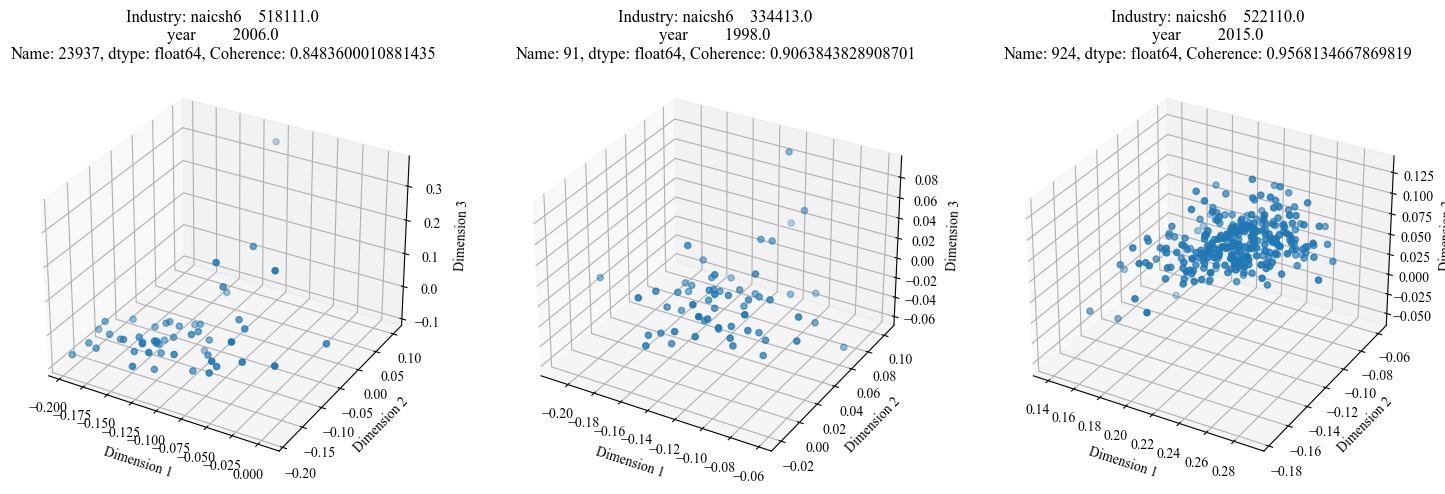

In [198]:

# Plot them in a 3-d plot using Dimension 1 2 and 3
fig = plt.figure(figsize=(18, 6))

for i, firms in enumerate(selected_firms):
    ax = fig.add_subplot(1,3 , i+1, projection='3d')
    ax.scatter(firms['Dimension 1'], firms['Dimension 2'], firms['Dimension 3'])
    ax.set_title(f'Industry: {industries[i]}, Coherence: {firms["category_coherence_naicsh6"].mean()}')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')

plt.show()

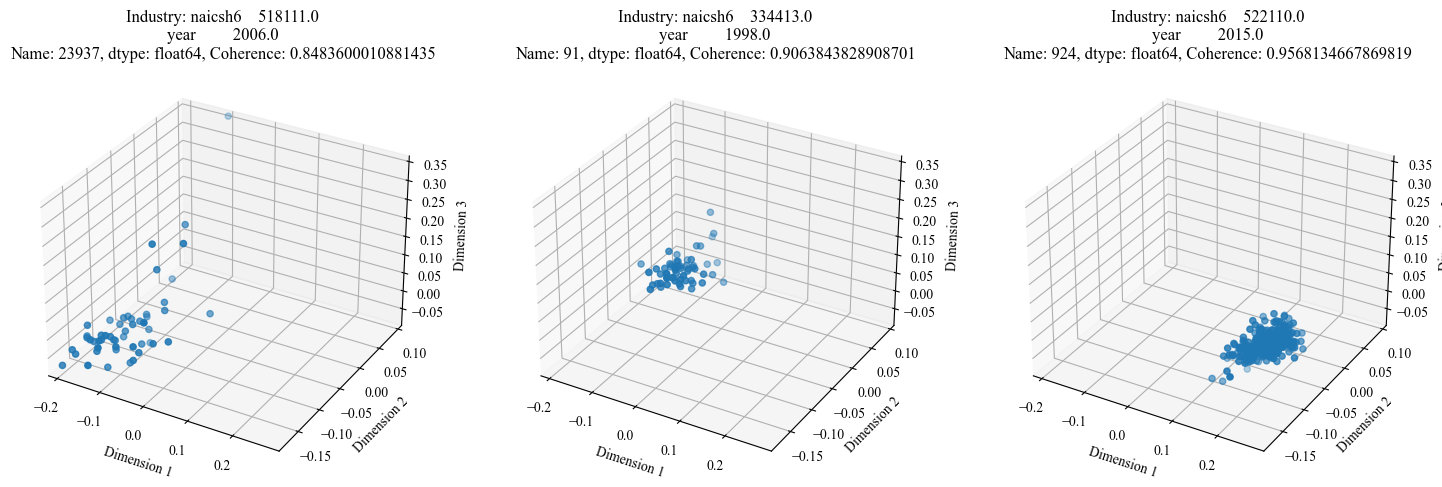

In [199]:
fig = plt.figure(figsize=(18, 6))

# calculate the limits
xmin = min(df['Dimension 1'].min() for df in selected_firms)
xmax = max(df['Dimension 1'].max() for df in selected_firms)
ymin = min(df['Dimension 2'].min() for df in selected_firms)
ymax = max(df['Dimension 2'].max() for df in selected_firms)
zmin = min(df['Dimension 3'].min() for df in selected_firms)
zmax = max(df['Dimension 3'].max() for df in selected_firms)

for i, firms in enumerate(selected_firms):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.scatter(firms['Dimension 1'], firms['Dimension 2'], firms['Dimension 3'])
    ax.set_title(f'Industry: {industries[i]}, Coherence: {firms["category_coherence_naicsh6"].mean()}')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')

    # set the limits
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_zlim([zmin, zmax])

plt.show()

In [21]:

# Merge on the date and CIK columns
wrds_index = pd.merge(wrds_index, compustat_select, on=['cik'], how='outer')
wrds_index['delta'] = wrds_index['datadate'] - wrds_index['rdate']
wrds_index['delta'] =wrds_index['delta'].dt.days
wrds_index = wrds_index[(wrds_index['delta']<10) & (wrds_index['delta']>-10)] # this could be changed to account for the fact that the filing date is not always the same as the date of the financial statement
wrds_index.drop_duplicates(['GVKEY', 'datadate'], inplace=True)



In [23]:
wrds_index[['GVKEY', 'datadate', 'rdate', 'fdate', 'datadate', 'year']]

,GVKEY,datadate,rdate,fdate,datadate,year
8,16609.0,1995-12-31,1995-12-31,19960329.0,1995-12-31,1995.0
16,16609.0,1996-12-31,1996-12-31,19970331.0,1996-12-31,1996.0
31,16609.0,1997-12-31,1997-12-31,19980414.0,1997-12-31,1997.0
39,16609.0,1998-12-31,1998-12-31,19990331.0,1998-12-31,1998.0
56,1094.0,2000-06-30,2000-06-30,20000928.0,2000-06-30,2000.0
...,...,...,...,...,...,...
2504660,39811.0,2021-12-31,2021-12-31,20220331.0,2021-12-31,2021.0
2504661,38288.0,2021-12-31,2021-12-31,20220321.0,2021-12-31,2021.0
2504662,39820.0,2021-12-31,2021-12-31,20220330.0,2021-12-31,2021.0
2504664,40417.0,2021-12-31,2021-12-31,20220331.0,2021-12-31,2021.0


## Nomic AI visulatization

In [76]:
from nomic import atlas


In [129]:
wrds_index_sample = wrds_index.copy()
doc_vectors_sample = doc_vectors.loc[wrds_index_sample['id']]

In [130]:
doc_vectors_sample_np = doc_vectors_sample.to_numpy()

In [131]:
wrds_index_sample.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'fdate', 'cik', 'findexdate',
       'lindexdate', 'form', 'coname', 'wrdsfname', 'fsize', 'doccount',
       'fname', 'rdate', 'secadate', 'secatime', 'secpdate', 'accession',
       'regcount', 'regseq', 'regrole', 'regcik', 'regfile_no', 'regfilm_no',
       'regconame', 'regfye', 'regsic', 'regstreet_hdq', 'regcity_hdq',
       'regstate_hdq', 'regzip_hdq', 'regstate_inc', 'regphone', 'regfconame',
       'regfchangedate', 'regirs', 'url', 'id', 'GVKEY', 'datadate', 'year',
       'month', 'cusip_8', 'conm', 'sich', 'naicsh', 'naicsh6', 'naicsh5',
       'naicsh4', 'naicsh3', 'naicsh2', 'delta', 'meanrec', 'numrec',
       'meanrec_mean', 'numrec_mean', 'meanrec_descend',
       'meanrec_mean_descend', 'numrec_mean_0', 'composite_var',
       'exemplar_naicsh6', 'exemplar_naicsh6_gvkey', 'exemplar_sim_naicsh6',
       'sim_mean_naicsh6', 'exemplar_naicsh6_typicality',
       'category_coherence_naicsh6', 'ind_vecs_change_naicsh6',
       'ind_si

In [135]:
wrds_index_sample[['id', 'coname', 'year', 'GVKEY','naics_code', 'naics_title']] = wrds_index_sample[['id', 'coname', 'year', 'GVKEY','naics_code', 'naics_title']].astype(str)
wrds_index_sample['datadate_dt'] = pd.to_datetime(wrds_index_sample['datadate']) 
wrds_index_sample = wrds_index_sample[['id', 'coname', 'year', 'datadate_dt','naics_code', 'naics_title']]

In [136]:
wrds_index_sample_dict = wrds_index_sample.to_dict('records')

In [139]:
project = atlas.map_embeddings(embeddings=doc_vectors_sample_np,
                               data=wrds_index_sample_dict,
                               id_field='id',
                               build_topic_model=True,
                               name= 'Map of 10-K filing Embeddings 1997-2022',
                               description= 'This map shows the embeddings of 10-K filings from 1997 to 2022. We have embedded the Item 1 section using MPNET Sentence Transformer',
                               is_public= True,
                               organization_name= "m.majzubi",
                               colorable_fields= ['naics_code', 'year']
                               )



2023-07-03 18:48:11.537 | INFO     | nomic.project:_create_project:753 - Creating project `Map of 10-K filing Embeddings 1997-2022` in organization `m.majzubi`
2023-07-03 18:48:14.157 | INFO     | nomic.atlas:map_embeddings:107 - Uploading embeddings to Atlas.
 23%|██▎       | 10/43 [00:08<00:12,  2.65it/s]2023-07-03 18:48:28.430 | ERROR    | nomic.project:_add_data:1321 - Shard upload failed: {"detail":"Uploading 2409 more datums exceeds your organization limit of 50000 datums per project. Contact support@nomic.ai to upgrade your limits."}
2023-07-03 18:48:29.025 | ERROR    | nomic.project:_add_data:1321 - Shard upload failed: {"detail":"Uploading 2409 more datums exceeds your organization limit of 50000 datums per project. Contact support@nomic.ai to upgrade your limits."}
2023-07-03 18:48:29.363 | ERROR    | nomic.project:_add_data:1321 - Shard upload failed: {"detail":"Uploading 2409 more datums exceeds your organization limit of 50000 datums per project. Contact support@nomic.ai t

# 2-D visualizations

In [144]:
# use UMAP to reduce dimensions
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(doc_vectors)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [145]:
embedding.shape

(242490, 2)

In [146]:
wrds_index.shape

(105584, 73)

In [148]:
# Convert the numpy array back to a pandas dataframe
umap_vecs = pd.DataFrame(embedding, index=doc_vectors.index, columns=["umap_x", "umap_y"])

# Merge the reduced_vectors dataframe with wrds_index using 'id' as the common identifier
merged_df = wrds_index.merge(umap_vecs, left_on='id', right_index=True, how='inner')

In [149]:
merged_df.shape

(105584, 75)

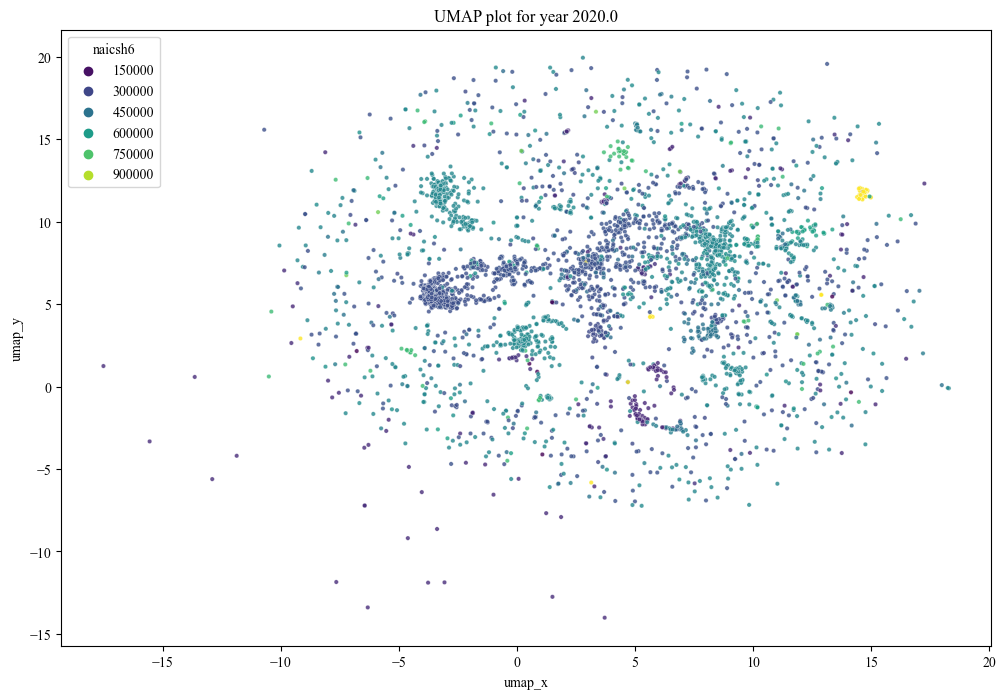

In [153]:
# group by year
grouped = merged_df.groupby('year')

# plot each year
for year, group in grouped:
    if year==2020:
        plt.figure(figsize=(12, 8))
        plt.title(f'UMAP plot for year {year}')
        sns.scatterplot(x='umap_x', y='umap_y', hue='naicsh6', data=group, palette='viridis', s=10, alpha=0.8)
        plt.show()

In [154]:
wrds_index.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'fdate', 'cik', 'findexdate',
       'lindexdate', 'form', 'coname', 'wrdsfname', 'fsize', 'doccount',
       'fname', 'rdate', 'secadate', 'secatime', 'secpdate', 'accession',
       'regcount', 'regseq', 'regrole', 'regcik', 'regfile_no', 'regfilm_no',
       'regconame', 'regfye', 'regsic', 'regstreet_hdq', 'regcity_hdq',
       'regstate_hdq', 'regzip_hdq', 'regstate_inc', 'regphone', 'regfconame',
       'regfchangedate', 'regirs', 'url', 'id', 'GVKEY', 'datadate', 'year',
       'month', 'cusip_8', 'conm', 'sich', 'naicsh', 'naicsh6', 'naicsh5',
       'naicsh4', 'naicsh3', 'naicsh2', 'delta', 'meanrec', 'numrec',
       'meanrec_mean', 'numrec_mean', 'meanrec_descend',
       'meanrec_mean_descend', 'numrec_mean_0', 'composite_var',
       'exemplar_naicsh6', 'exemplar_naicsh6_gvkey', 'exemplar_sim_naicsh6',
       'sim_mean_naicsh6', 'exemplar_naicsh6_typicality',
       'category_coherence_naicsh6', 'ind_vecs_change_naicsh6',
       'ind_si